<a href="https://colab.research.google.com/github/peppefdf/CSL_Gipuzkoa/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


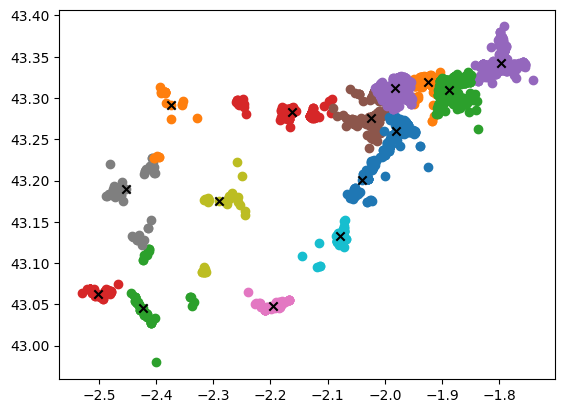

                          highway public_transport                   geometry  \
element_type osmid                                                              
node         1745450744  bus_stop         platform  POINT (-2.05273 43.18991)   
             1745450776  bus_stop         platform  POINT (-2.05168 43.19655)   
             1745450823  bus_stop         platform  POINT (-2.05290 43.18983)   
             1745450827  bus_stop         platform  POINT (-2.05357 43.19321)   
             3252355213  bus_stop         platform  POINT (-2.03476 43.20990)   

                        bench  bin  bus  lit       name operator   ref  \
element_type osmid                                                       
node         1745450744   NaN  NaN  NaN  NaN        NaN      NaN   NaN   
             1745450776   NaN  NaN  NaN  NaN        NaN      NaN   NaN   
             1745450823   NaN  NaN  NaN  NaN        NaN      NaN   NaN   
             1745450827   NaN  NaN  NaN  NaN        NaN      N

In [23]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from google.colab import drive

#n_skip = 10
n_clusters = 15

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta.csv", encoding='latin-1')

#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

ori_lat = 43.13525255625577
ori_lon = -2.080054227169231

model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(lat_lon)
# assign a cluster to each example
yhat = model.predict(lat_lon)
# retrieve unique clusters
clusters = np.unique(yhat)

centers = np.array(model.cluster_centers_)

cont_cluster = 0
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     d = sum((p-q)**2 for p, q in zip(centers[cont_cluster], lat_lon[row_ix[0][i_cl]]))**.5
     dist.append(d)
     X.append(lat_lon[row_ix[0][i_cl]][0])
     Y.append(lat_lon[row_ix[0][i_cl]][1])

 # find index of the point with minimum distance from cluster center
 index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 centers[cont_cluster][0] = lat_lon[row_ix[0][index_min]][0]
 centers[cont_cluster][1] = lat_lon[row_ix[0][index_min]][1]

 cont_cluster+=1
 plt.scatter(Y,X)

# plot centers
#centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
plt.show()

tags = {'highway':'bus_stop',
        'bus':'yes',
        'public_transport':['stop_position','platform']}

bus_stops = []
for i in range(len(centers)):
    lat = centers[i][0]
    lon = centers[i][1]
    try:
       gdf = ox.features.features_from_point((lat, lon), dist=1500, tags=tags)
       print(gdf.head())
       print('Closest stop for cluster ',i,':')
       temp0 = gdf[['geometry']].values[0][0]
       print(temp0.x, temp0.y)
       bus_stops.append((temp0.y, temp0.x))
    except:
       print('WARNING: stops not found for cluster ',i)
       #print(centers[i])
    print()


map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
#for i in range(len(lat_lon)):
for i in range(len(bus_stops)):
    #lat = lat_lon[i][0]
    #lon = lat_lon[i][1]
    lat = bus_stops[i][0]
    lon = bus_stops[i][1]
    #lat = centers[i][0]
    #lon = centers[i][1]
    folium.Marker((lat,lon)).add_to(map)
map
